### REGRESIÓN LINEAL EN PYTHON Y VARIABLES PROXY (Cont.)

##### Para esta clase continuamos usando como referencia la hipótesis y datos utilizados en el artículo: **"The Colonial Origins of Comparative Development: An Empirical Investigation"**

* Autores: Daron Acemoglu, Simon Johnson, James A. Robinson

* Fuente: The American Economic Review, Vol. 91, No. 5 (Dec., 2001), pp. 1369-1401 https://economics.mit.edu/files/4123

* La versión en español la pueden encontrar en  redalyc.org/pdf/419/41901302.pdf

### 1.- Importando las librerías necesarias
* Para esta clase necesitamos instalar linearmodels

In [1]:
#!pip install linearmodels

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IVLIML, IV2SLS, IVLIML, IVGMM, IVGMMCUE

#
import warnings
warnings.filterwarnings('ignore')

### 2.- Endogeneidad Modelo de Mínimos Cuadrados en dos etapas
* **Endogeneidad** puede surgir como resultado de un error de medición, autorregresión con autocorrelación de errores, simultaneidad y variables omitidas. Utilizando un modelo OLS de dos etapas revisaremos cómo podemos arreglar este problema.

* La relación que existe entre el Índice de protección  promedio contra el riesgo de expropiación ('avexpr') y el    Logaritmo del PIB per cápita, puede ser bidireccional. 
* Por ejemplo, es probable que los países más ricos puedan financiar o preferir mejores instituciones; o que las variables que afectan el ingreso también pueden estar correlacionadas con diferencias institucionales; también podría se plausible que  la construcción del índice de protección  promedio contra el riesgo de expropiación pudo sesgarse,  los analistas pueden estar predispuestos a ver que los países con mayores ingresos tengan mejores instituciones

In [2]:
df1 = pd.read_stata('maketable1.dta')
df1.head()

,shortnam,euro1900,excolony,avexpr,logpgp95,cons1,cons90,democ00a,cons00a,extmort4,logem4,loghjypl,baseco
0,AFG,0.000000,1.0,NaN,NaN,1.0,2.0,1.0,1.0,93.699997,4.540098,NaN,NaN
1,AGO,8.000000,1.0,5.363636,7.770645,3.0,3.0,0.0,1.0,280.000000,5.634789,-3.411248,1.0
2,ARE,0.000000,1.0,7.181818,9.804219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ARG,60.000004,1.0,6.386364,9.133459,1.0,6.0,3.0,3.0,68.900002,4.232656,-0.872274,1.0
4,ARM,0.000000,0.0,NaN,7.682482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.- Instrumentos y Método de Variables Intrumentales en dos etapas

* Instrimentemos nuestro índice de protección a la democracia a través de una variable instrumental: la tasa de mortalidad de los primeros colonizadores.

* De esta forma utilizaremos el procedimiento de estimación de Mínimos Cuadros en Dos Etapas. Podemos utilizar el estimador de Variables Instrumentales para determinar (Segunda Etapa):

$$\hat{\boldsymbol{\beta}}^{IV} = (\hat{\mathbf{X}}' \mathbf{X})^{-1} \hat{\mathbf{X}}' \mathbf{Y}$$

* Por otro lado, podemoos establecer el siguiente vector de innstrumentos:
\begin{equation*}
    \mathbf{z}_i = (1, x_{i1}, \ldots, x_{iK-1}, z_{i1}, \ldots, z_{iM})
\end{equation*}

* Contruyendo de forma simimar a otras matrices a $\mathbf{Z}$ apilado la información de cada uno de los individuos. De esta forma podremos constriuir $\hat{\mathbf{X}}$ mediante el uso de un estimador de MCO:
\begin{eqnarray*}
    \hat{\mathbf{X}} & = & \mathbf{Z} \hat{\boldsymbol{\gamma}} \\
    & = & \mathbf{Z} (\mathbf{Z}' \mathbf{Z})^{-1} \mathbf{Z}' \mathbf{X}
\end{eqnarray*}

* De lo anterior tendríamos que (Primera Etapa):
\begin{equation*}
    \hat{\mathbf{X}}' = \mathbf{X}' \mathbf{Z} (\mathbf{Z}' \mathbf{Z})^{-1} \mathbf{Z}'
\end{equation*}

* Sólo para poner en contexto, podemos platear el Método Generalizado de Momentos de la siguiente forma:


$$\hat{\boldsymbol{\beta}}^{GMM} = (\hat{\mathbf{X}}' \hat{\mathbf{W}} \mathbf{X})^{-1} \hat{\mathbf{X}}'\hat{\mathbf{W}} \mathbf{Y}$$

Donde $\hat{\mathbf{W}}$ es una matriz definida positiva.

In [3]:
# Borrado de NA's 
df1_subset2 = df1.dropna(subset=['logem4', 'avexpr'])

X = df1_subset2['logem4']
y = df1_subset2['avexpr']
labels = df1_subset2['shortnam']

* Hacemos una gráfico para ilustrar la relación entre las variables

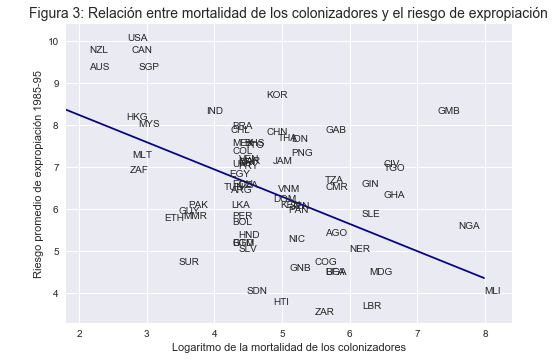

In [4]:
plt.style.use('seaborn')

# 
fig, ax = plt.subplots()
ax.scatter(X, y, marker = '')

for i, label in enumerate(labels):
    ax.annotate(label, (X.iloc[i], y.iloc[i]))

# Línea de tendencia
ax.plot(np.unique(X),
         np.poly1d(np.polyfit(X, y, 1))(np.unique(X)),
         color = 'darkblue')

ax.set_xlim([1.8,8.4])
ax.set_ylim([3.3,10.4])
ax.set_xlabel('Logaritmo de la mortalidad de los colonizadores')
ax.set_ylabel('Riesgo promedio de expropiación 1985-95')
ax.set_title('Figura 3: Relación entre mortalidad de los colonizadores y el riesgo de expropiación'
            , size = 14)

#
plt.show()

### 4. Primera Etapa: Para la primera etapa requerimos instrumentar el riesgo de expropiación

$$avexpr_i = \delta_0 + \delta_1 logem4_i + \nu_i$$

In [5]:
# Import and select the data
df4 = pd.read_stata('maketable4.dta')
df4 = df4[df4['baseco'] == 1]
df4.head()

,shortnam,africa,lat_abst,rich4,avexpr,logpgp95,logem4,asia,loghjypl,baseco
1,AGO,1.0,0.136667,0.0,5.363636,7.770645,5.634789,0.0,-3.411248,1.0
3,ARG,0.0,0.377778,0.0,6.386364,9.133459,4.232656,0.0,-0.872274,1.0
5,AUS,0.0,0.300000,1.0,9.318182,9.897972,2.145931,0.0,-0.170788,1.0
11,BFA,1.0,0.144444,0.0,4.454545,6.845880,5.634789,0.0,-3.540459,1.0
12,BGD,0.0,0.266667,0.0,5.136364,6.877296,4.268438,1.0,-2.063568,1.0


In [6]:
# 
df4['const'] = 1

# Regresión
results_fs = sm.OLS(df4['avexpr'],
                    df4[['const', 'logem4']],
                    missing='drop').fit()
print(results_fs.summary())

                            OLS Regression Results                            
Dep. Variable:                 avexpr   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     22.95
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           1.08e-05
Time:                        08:28:01   Log-Likelihood:                -104.83
No. Observations:                  64   AIC:                             213.7
Df Residuals:                      62   BIC:                             218.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3414      0.611     15.296      0.0

### 4. Segunda Etapa: En la segunda etapa estimamos la ecuación de interés

$$logpgp95_i = β_0 + β_1 \widehat{avexpr}_i + \varepsilon_i$$

In [7]:
# Tomamos el valor predicho de la Primera Etapa:
df4['predicted_avexpr'] = results_fs.predict()

df4.head()

,shortnam,africa,lat_abst,rich4,avexpr,logpgp95,logem4,asia,loghjypl,baseco,const,predicted_avexpr
1,AGO,1.0,0.136667,0.0,5.363636,7.770645,5.634789,0.0,-3.411248,1.0,1,5.922342
3,ARG,0.0,0.377778,0.0,6.386364,9.133459,4.232656,0.0,-0.872274,1.0,1,6.773127
5,AUS,0.0,0.300000,1.0,9.318182,9.897972,2.145931,0.0,-0.170788,1.0,1,8.039306
11,BFA,1.0,0.144444,0.0,4.454545,6.845880,5.634789,0.0,-3.540459,1.0,1,5.922342
12,BGD,0.0,0.266667,0.0,5.136364,6.877296,4.268438,1.0,-2.063568,1.0,1,6.751415


In [8]:
# Etimamos la Segunda Etapa, mediante la estimación de la ecuación de interés
results_ss = sm.OLS(df4['logpgp95'],
                    df4[['const', 'predicted_avexpr']]).fit()
print(results_ss.summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     56.60
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           2.66e-10
Time:                        08:30:14   Log-Likelihood:                -72.268
No. Observations:                  64   AIC:                             148.5
Df Residuals:                      62   BIC:                             152.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.9097      0.823  

### 5. Estimación en una sola instrucción: IV2SLS

In [12]:
# Sin estimación de ajuste de errores
iv = IV2SLS(dependent=df4['logpgp95'],
            exog=df4['const'],
            endog=df4['avexpr'],
            instruments=df4[['logem4']]).fit()#cov_type='unadjusted')

print(iv.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:               logpgp95   R-squared:                      0.1870
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1739
No. Observations:                  64   F-statistic:                    28.754
Date:                Mon, Apr 12 2021   P-value (F-stat)                0.0000
Time:                        08:34:15   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          1.9097     1.1740     1.6267     0.1038     -0.3912      4.2106
avexpr         0.9443     0.1761     5.3623     0.00